In [25]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, Markdown

## Important

$$
CVaR_w (\alpha) = -E[r_w \ | \ r_w \leq -VaR_w (\alpha)]
$$


$$
C_{(i)}CVaR_w (\alpha) = -E[w_{(i)}r_{(i)} \ | \ r_w \leq -VaR_w (\alpha)]
$$


$$
\%C_{(i)}CVaR_w(\alpha) = \frac{E[w_{(i)}r_{(i)} \ | \ r_w \leq -VaR_w(\alpha)]}{E[r_w \ | \ r_w \leq -VaR_w(\alpha)]}
$$

MCC portfolio:

$$
w^{MCC} = argmin \ C_w (\alpha)
$$

$$
\ \ w \in W
$$

where

$$
C_w(\alpha) = max_i \ C_{(i)}CVaR_w (\alpha)
$$

The other two strategies are the minimum CVaR (MC) and equal-weight (EW) portfolios:

$$
w^{minCVaR} = argmin_{w \in W}CVaR_w (\alpha) \ \text{and} \ w^{EW} = (1/N, ... , 1/N)'
$$

## Download data

In [26]:
# bonds, commodities, equities and real estate
tickers = ['VBTLX', 'GSG', 'VTI', 'VNQ']
start_date = '2019-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start_date, end_date)['Adj Close']

# calculate returns
returns = data.pct_change().dropna()

# defining alpha and the number of assets
alpha = 0.05
n_assets = len(returns.columns)

[*********************100%***********************]  4 of 4 completed


## Calculate CVaR

In [27]:
# CVaR for only long positions
def portfolio_return(returns, weights):
    return np.dot(returns, weights)

# Better way to calculate CVaR than the one used in my homework 1. I used .query in the homework, but checking with friends this way is better.
def cvar(portfolio_returns, alpha):
    var = np.percentile(portfolio_returns, alpha*100)
    cvar = -portfolio_returns[portfolio_returns < var].mean()
    return cvar

def individual_cvar_contributions(weights, returns, alpha):
    portfolio_returns = portfolio_return(returns, weights)
    var = np.percentile(portfolio_returns, alpha*100)

    # check which days are in the cvar for the portfolio
    bad_days_portfolio = portfolio_returns < var

    contributions = []
    # chech the returns of each asset the days where the portfolio is in the cvar to know the contribution
    for i in range(n_assets):
        asset_contribution = -returns.iloc[:, i][bad_days_portfolio].mean() * weights[i]
        contributions.append(asset_contribution)
    
    portfolio_cvar = cvar(portfolio_returns, alpha)

    percentage_contributions = []
    for j in range(len(contributions)):
        pct_contributions = contributions[j] / portfolio_cvar
        percentage_contributions.append(pct_contributions)
    
    return contributions

## Optimization

In [28]:
def optimal_mcc(weights, returns, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights = result.x



def min_cvar(weights, returns, alpha):
    portfolio_returns = portfolio_return(returns, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights = result_min_cvar.x


## Weights and Contributions

In [29]:
mcc_cvar_contrubutions = individual_cvar_contributions(mcc_weights, returns, alpha)
mcc_cvar = cvar(portfolio_return(returns, mcc_weights), alpha)
mcc_cvar_pct_contributions = mcc_cvar_contrubutions / mcc_cvar

min_cvar_cvar_contrubutions = individual_cvar_contributions(min_cvar_weights, returns, alpha)
min_cvar_cvar = cvar(portfolio_return(returns, min_cvar_weights), alpha)
min_cvar_cvar_pct_contributions = min_cvar_cvar_contrubutions / min_cvar_cvar

ew_weights = np.ones(n_assets) / n_assets
ew_cvar_contrubutions = individual_cvar_contributions(ew_weights, returns, alpha)
ew_cvar = cvar(portfolio_return(returns, ew_weights), alpha)
ew_cvar_pct_contributions = ew_cvar_contrubutions / ew_cvar

In [30]:
print(f'MCC Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {mcc_weights[i]:.3%}')
print('---------------------')

print()

print(f'MCC Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {mcc_cvar_pct_contributions[i]:.3%}')
print('---------------------')

print()
print()

print(f'Min CVaR Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {min_cvar_weights[i]:.3%}')
print('---------------------')

print()

print(f'Min CVaR Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {min_cvar_cvar_pct_contributions[i]:.3%}')
print('---------------------')

print()
print()

print(f'Equal-Weight Portfolio weights:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {ew_weights[i]:.3%}')
print('---------------------')

print()

print(f'Equal-Weight Portfolio CVaR percentage contribution:')
print('---------------------')
for i in range(n_assets):
    print(f'{returns.keys()[i]}: {ew_cvar_pct_contributions[i]:.3%}')
print('---------------------')

MCC Portfolio weights:
---------------------
GSG: 12.095%
VBTLX: 66.010%
VNQ: 10.182%
VTI: 11.713%
---------------------

MCC Portfolio CVaR percentage contribution:
---------------------
GSG: 25.518%
VBTLX: 25.379%
VNQ: 25.507%
VTI: 23.596%
---------------------


Min CVaR Portfolio weights:
---------------------
GSG: 3.740%
VBTLX: 95.629%
VNQ: 0.000%
VTI: 0.631%
---------------------

Min CVaR Portfolio CVaR percentage contribution:
---------------------
GSG: 3.752%
VBTLX: 95.614%
VNQ: 0.000%
VTI: 0.633%
---------------------


Equal-Weight Portfolio weights:
---------------------
GSG: 25.000%
VBTLX: 25.000%
VNQ: 25.000%
VTI: 25.000%
---------------------

Equal-Weight Portfolio CVaR percentage contribution:
---------------------
GSG: 32.878%
VBTLX: 0.759%
VNQ: 35.476%
VTI: 30.888%
---------------------


## Static Backtesting

In [31]:
# bonds, commodities, equities and real estate
tickers = ['VBTLX', 'GSG', 'VTI', 'VNQ']
data = yf.download(tickers, end_date, end='2024-12-31')['Adj Close']

# calculate returns
returns = data.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed


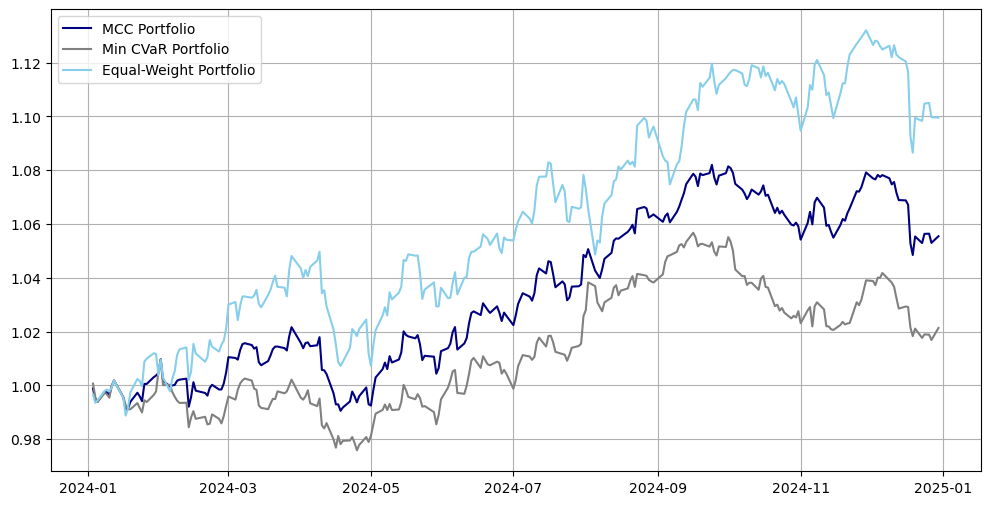

In [32]:
mcc_portfolio_returns = portfolio_return(returns, mcc_weights)
cumulative_return_mcc_port = (1 + mcc_portfolio_returns).cumprod()

min_cvar_portfolio_returns = portfolio_return(returns, min_cvar_weights)
cumulative_return_min_cvar_port = (1 + min_cvar_portfolio_returns).cumprod()

ew_portfolio_returns = portfolio_return(returns, ew_weights)
cumulative_return_ew_port = (1 + ew_portfolio_returns).cumprod()

cumulative_returns_df = pd.DataFrame({
    'MCC Portfolio': cumulative_return_mcc_port,
    'Min CVaR Portfolio': cumulative_return_min_cvar_port,
    'Equal-Weight Portfolio': cumulative_return_ew_port
})
cumulative_returns_df.index = returns.index

plt.figure(figsize=(12, 6))

plt.plot(cumulative_returns_df['MCC Portfolio'], label='MCC Portfolio', c = 'navy')
plt.plot(cumulative_returns_df['Min CVaR Portfolio'], label='Min CVaR Portfolio', c = 'gray')
plt.plot(cumulative_returns_df['Equal-Weight Portfolio'], label='Equal-Weight Portfolio', c = 'skyblue')

plt.legend()
plt.grid();

In [33]:
returns_df = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns,
    'Min CVaR Portfolio': min_cvar_portfolio_returns,
    'Equal-Weight Portfolio': ew_portfolio_returns
})

summary_df = pd.DataFrame({
    'Return (%)': (cumulative_returns_df.iloc[-1] - 1) * 100,
        'Annualized Volatility (%)': returns_df.std() * np.sqrt(252) * 100
})
summary_df

,Return (%),Annualized Volatility (%)
MCC Portfolio,5.545897,5.431432
Min CVaR Portfolio,2.136466,5.134017
Equal-Weight Portfolio,9.952937,7.896685


## Dynamic Backtesting

In [34]:
# bonds, commodities, equities and real estate
tickers = ['VBTLX', 'GSG', 'VTI', 'VNQ']
start_date = '2019-01-01'
q1 = '2024-01-01'
end_q1 = '2024-03-31'
end_q2 = '2024-06-30'
end_q3 = '2024-09-30'
end_q4 = '2024-12-31'

data = yf.download(tickers, start_date, q1)['Adj Close']
data_q1_train = yf.download(tickers, start_date, end_q1)['Adj Close']
data_q2_train = yf.download(tickers, start_date, end_q2)['Adj Close']
data_q3_train = yf.download(tickers, start_date, end_q3)['Adj Close']
data_q4_train = yf.download(tickers, start_date, end_q4)['Adj Close']

data_q1_test = yf.download(tickers, q1, end_q1)['Adj Close']
data_q2_test = yf.download(tickers, end_q1, end_q2)['Adj Close']
data_q3_test = yf.download(tickers, end_q2, end_q3)['Adj Close']
data_q4_test = yf.download(tickers, end_q3, end_q4)['Adj Close']


# calculate returns
returns = data.pct_change().dropna()
returns_q1_train = data_q1_train.pct_change().dropna()
returns_q2_train = data_q2_train.pct_change().dropna()
returns_q3_train = data_q3_train.pct_change().dropna()
returns_q4_train = data_q4_train.pct_change().dropna()

returns_q1_test = data_q1_test.pct_change().dropna()
returns_q2_test = data_q2_test.pct_change().dropna()
returns_q3_test = data_q3_test.pct_change().dropna()
returns_q4_test = data_q4_test.pct_change().dropna()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


### Q1

In [35]:
def optimal_mcc(weights, returns, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights_q1 = result.x



def min_cvar(weights, returns, alpha):
    portfolio_returns = portfolio_return(returns, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights_q1 = result_min_cvar.x
mcc_weights_q1

array([0.12094613, 0.66010014, 0.10182415, 0.11712958])

In [36]:
mcc_portfolio_returns_q1 = np.dot(mcc_weights_q1, returns_q1_test.T)

min_cvar_portfolio_returns_q1 = np.dot(min_cvar_weights_q1, returns_q1_test.T)

ew_portfolio_returns_q1 = np.dot(ew_weights, returns_q1_test.T)


returns_df_q1 = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns_q1,
    'Min CVaR Portfolio': min_cvar_portfolio_returns_q1,
    'Equal-Weight Portfolio': ew_portfolio_returns_q1
})
returns_df_q1.index = returns_q1_test.index

### Q2

In [37]:
def optimal_mcc(weights, returns_q1_train, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns_q1_train, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns_q1_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights_q2 = result.x



def min_cvar(weights, returns_q1_train, alpha):
    portfolio_returns = portfolio_return(returns_q1_train, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns_q1_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights_q2 = result_min_cvar.x
mcc_weights_q2

array([0.12429901, 0.64508209, 0.1033224 , 0.12729649])

In [38]:
mcc_portfolio_returns_q2 = np.dot(mcc_weights_q2, returns_q2_test.T)

min_cvar_portfolio_returns_q2 = np.dot(min_cvar_weights_q2, returns_q2_test.T)

ew_portfolio_returns_q2 = np.dot(ew_weights, returns_q2_test.T)


returns_df_q2 = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns_q2,
    'Min CVaR Portfolio': min_cvar_portfolio_returns_q2,
    'Equal-Weight Portfolio': ew_portfolio_returns_q2
})
returns_df_q2.index = returns_q2_test.index

### Q3

In [39]:
def optimal_mcc(weights, returns_q2_train, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns_q2_train, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns_q2_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights_q3 = result.x



def min_cvar(weights, returns_q2_train, alpha):
    portfolio_returns = portfolio_return(returns_q2_train, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns_q2_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights_q3 = result_min_cvar.x
mcc_weights_q3

array([0.25930159, 0.25930159, 0.22384416, 0.25755267])

In [40]:
mcc_portfolio_returns_q3 = np.dot(mcc_weights_q3, returns_q3_test.T)

min_cvar_portfolio_returns_q3 = np.dot(min_cvar_weights_q3, returns_q3_test.T)

ew_portfolio_returns_q3 = np.dot(ew_weights, returns_q3_test.T)


returns_df_q3 = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns_q3,
    'Min CVaR Portfolio': min_cvar_portfolio_returns_q3,
    'Equal-Weight Portfolio': ew_portfolio_returns_q3
})
returns_df_q3.index = returns_q3_test.index

### Q4

In [41]:
def optimal_mcc(weights, returns_q3_train, alpha):
    cvar_contributions = individual_cvar_contributions(weights, returns_q3_train, alpha)
    return np.max(cvar_contributions)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},
]
bounds = tuple((0, 1) for _ in range(n_assets))

# Initial guess
initial_weights = np.ones(n_assets) / n_assets

result = minimize(
    fun=optimal_mcc,
    x0=initial_weights,
    args=(returns_q3_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
mcc_weights_q4 = result.x



def min_cvar(weights, returns_q3_train, alpha):
    portfolio_returns = portfolio_return(returns_q3_train, weights)
    return cvar(portfolio_returns, alpha)

result_min_cvar = minimize(
    fun=min_cvar,
    x0=initial_weights,
    args=(returns_q3_train, alpha),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    tol=1e-8
)
min_cvar_weights_q4 = result_min_cvar.x
mcc_weights_q4

array([0.12508785, 0.64915955, 0.09968319, 0.12606941])

In [42]:
mcc_portfolio_returns_q4 = np.dot(mcc_weights_q4, returns_q4_test.T)

min_cvar_portfolio_returns_q4 = np.dot(min_cvar_weights_q4, returns_q4_test.T)

ew_portfolio_returns_q4 = np.dot(ew_weights, returns_q4_test.T)


returns_df_q4 = pd.DataFrame({
    'MCC Portfolio': mcc_portfolio_returns_q4,
    'Min CVaR Portfolio': min_cvar_portfolio_returns_q4,
    'Equal-Weight Portfolio': ew_portfolio_returns_q4
})
returns_df_q4.index = returns_q4_test.index

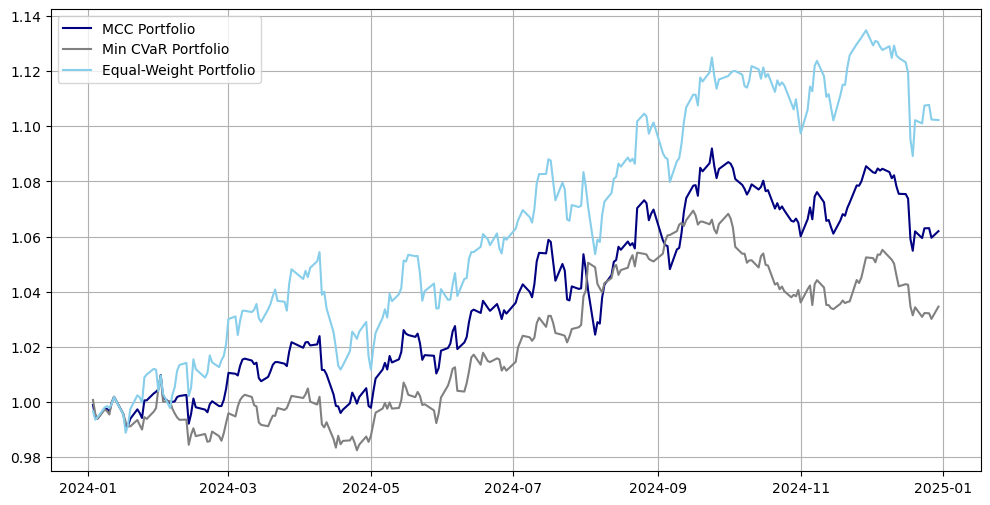

In [43]:
combined_returns_df = pd.concat([returns_df_q1, returns_df_q2, returns_df_q3, returns_df_q4])
cumulative_combined_returns_df = (1 + combined_returns_df).cumprod()

plt.figure(figsize=(12, 6))

plt.plot(cumulative_combined_returns_df['MCC Portfolio'], label='MCC Portfolio', c = 'navy')
plt.plot(cumulative_combined_returns_df['Min CVaR Portfolio'], label='Min CVaR Portfolio', c = 'gray')
plt.plot(cumulative_combined_returns_df['Equal-Weight Portfolio'], label='Equal-Weight Portfolio', c = 'skyblue')

plt.legend()
plt.grid();

In [44]:
summary_dynamic_df = pd.DataFrame({
    'Return (%)': (cumulative_combined_returns_df.iloc[-1] - 1) * 100,
        'Annualized Volatility (%)': combined_returns_df.std() * np.sqrt(252) * 100
})
summary_dynamic_df

,Return (%),Annualized Volatility (%)
MCC Portfolio,6.194313,6.417643
Min CVaR Portfolio,3.456562,5.065384
Equal-Weight Portfolio,10.225850,7.927383


## Results

In [45]:
display(Markdown('### Summary of Static Portfolios'))
display(summary_df)
print()
display(Markdown('### Summary of Dynamic Portfolios'))
display(summary_dynamic_df)

### Summary of Static Portfolios

,Return (%),Annualized Volatility (%)
MCC Portfolio,5.545897,5.431432
Min CVaR Portfolio,2.136466,5.134017
Equal-Weight Portfolio,9.952937,7.896685


### Summary of Dynamic Portfolios

,Return (%),Annualized Volatility (%)
MCC Portfolio,6.194313,6.417643
Min CVaR Portfolio,3.456562,5.065384
Equal-Weight Portfolio,10.225850,7.927383


The results show that all three strategies yield slightly higher returns when the portfolios are rebalanced, excluding any transaction costs.